In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np


In [2]:
size = 120
noise_std = 5e-2
alpha = .2
lr = 1e-2

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(1000)


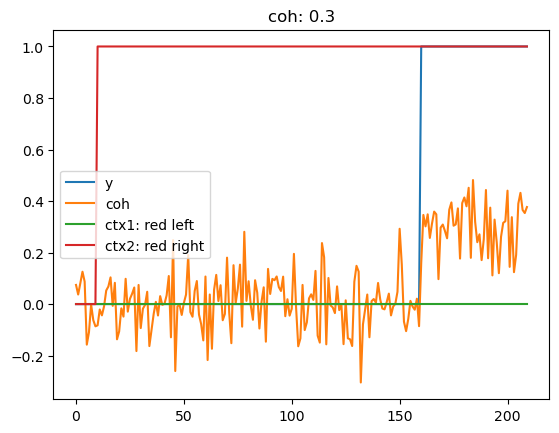

In [4]:
n = 4

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], label = 'ctx1: red left')
plt.plot(x_val[n,:,2], label = 'ctx2: red right')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




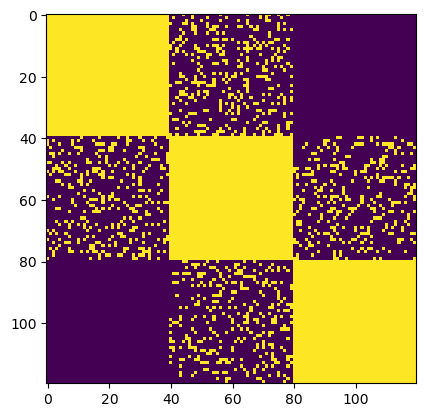

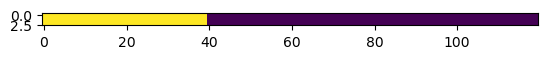

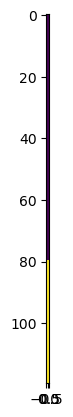

In [5]:
# modify the connectivity matrix to be 3-area

wrec_mask = np.zeros((size, size))

a = np.random.rand(40,40) > 0.8
b = np.random.rand(40,40) > 0.8
c = np.random.rand(40,40) > 0.8
d = np.random.rand(40,40) > 0.8

wrec_mask[0:40, 0:40] = 1
wrec_mask[40:80, 40:80] = 1
wrec_mask[80:size, 80:size] = 1

wrec_mask[40:80,0:40] = a
wrec_mask[80:size,40:80] = b
wrec_mask[0:40,40:80] = c
wrec_mask[40:80,80:size] = d

plt.figure()
plt.imshow(wrec_mask)
plt.show()

wrec_mask1 = torch.tensor(wrec_mask)
wrec_mask1 = wrec_mask1.float()



wi_mask = np.zeros((input_size, size))
wi_mask[:,:40] = 1
wi_mask1 = torch.tensor(wi_mask)
wi_mask1 = wi_mask1.float()


wo_mask = np.zeros((size, output_size))
wo_mask[80:size,:] = 1
wo_mask1 = torch.tensor(wo_mask)
wo_mask1 = wo_mask1.float()

plt.figure()
plt.imshow(wi_mask)
plt.show()

plt.figure()
plt.imshow(wo_mask)
plt.show()


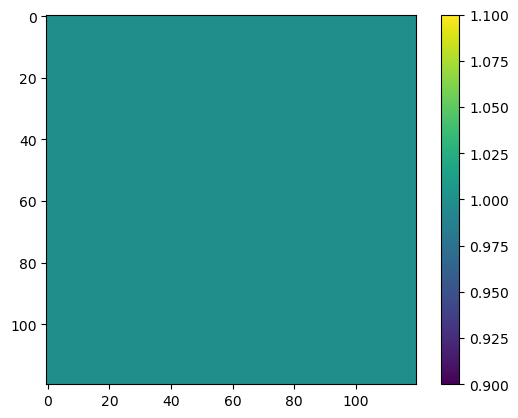

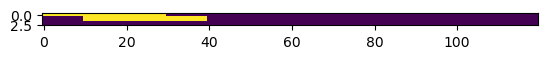

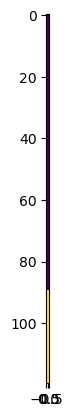

In [6]:
# or make connectivity matrix a diffusion matrix 

wrec_mask = np.zeros((size, size))

# for i in range(size):
#     for j in range(size):
#         chance = np.abs(i-j)/100
#         rand_num = random.random()
#         connect = 0
#         if rand_num >= chance:
#             connect = 1
#         else: 
#             connect = 0
#         wrec_mask[i,j] = connect

        
wrec_mask = np.ones((size, size))
plt.figure()
plt.imshow(wrec_mask)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

wrec_mask1 = torch.tensor(wrec_mask)
wrec_mask1 = wrec_mask1.float()


wi_mask = np.zeros((input_size, size))
wi_mask[0,:30] = 1
wi_mask[1:2,10:40] = 1

wi_mask1 = torch.tensor(wi_mask)
wi_mask1 = wi_mask1.float()


wo_mask = np.zeros((size, output_size))
wo_mask[90:size,:] = 1
wo_mask1 = torch.tensor(wo_mask)
wo_mask1 = wo_mask1.float()

plt.figure()
plt.imshow(wi_mask)
plt.show()

plt.figure()
plt.imshow(wo_mask)
plt.show()

In [7]:
# net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
#                   wrec_mask= wrec_mask1)

hidden_size = size
net = FullRankRNN(3, hidden_size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask= wrec_mask1, wi_mask = wi_mask1, wo_mask = wo_mask1)


# train a full-rank RNN

In [8]:


net.non_linearity = torch.relu
net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr / sqrt(size), batch_size=50, keep_best=True, cuda=True, early_stop=0.2)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)

# will only choose 1 of the 2  
# out = net.forward(x_val)
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the model
# torch.save(net.state_dict(), f'../models/TF{size}.pt')

Training...
initial loss: 0.998
epoch 0:  loss=0.957  (took 2.28 s) *
epoch 1:  loss=0.749  (took 2.21 s) *
epoch 2:  loss=0.533  (took 2.16 s) *
epoch 3:  loss=0.389  (took 2.35 s) *
epoch 4:  loss=0.306  (took 2.16 s) *
epoch 5:  loss=0.270  (took 2.18 s) *
epoch 6:  loss=0.246  (took 2.22 s) *
epoch 7:  loss=0.222  (took 2.16 s) *
epoch 8:  loss=0.220  (took 2.25 s) *
epoch 9:  loss=0.215  (took 2.33 s) *
epoch 10:  loss=0.211  (took 2.30 s) *
epoch 11:  loss=0.195  (took 2.19 s) *
loss=0.181, acc=1.000


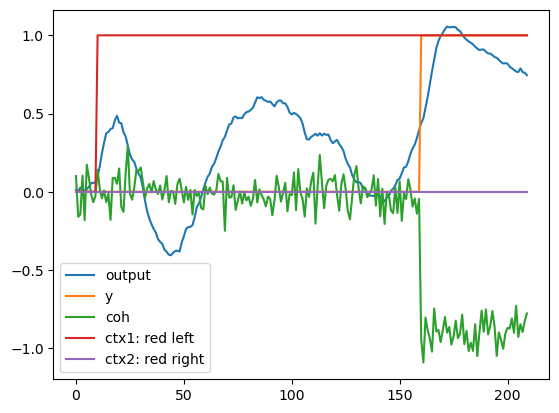

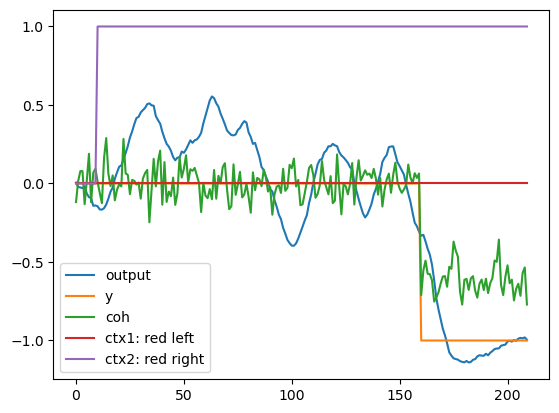

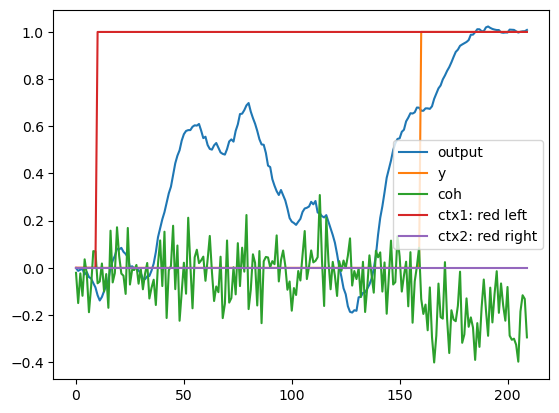

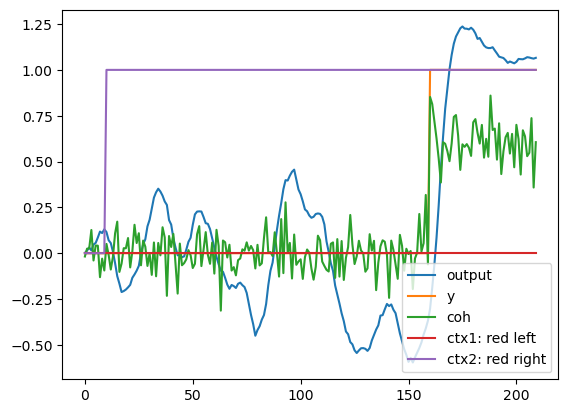

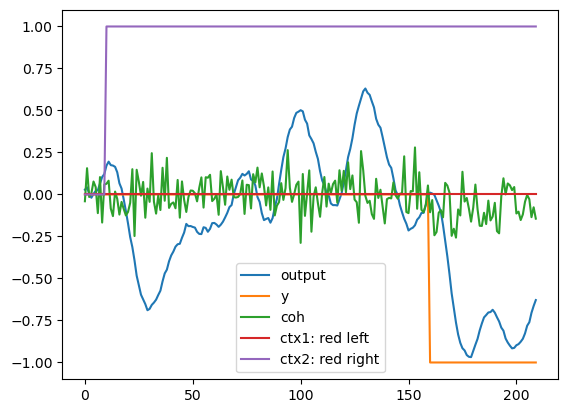

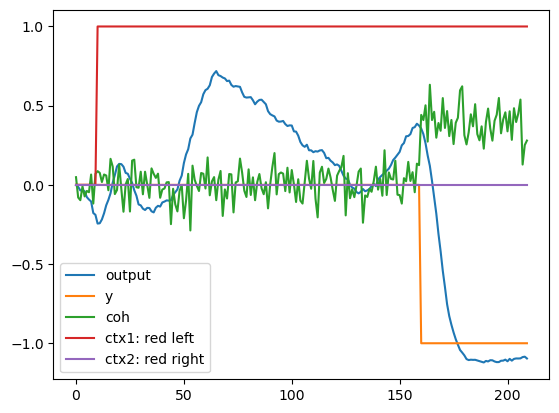

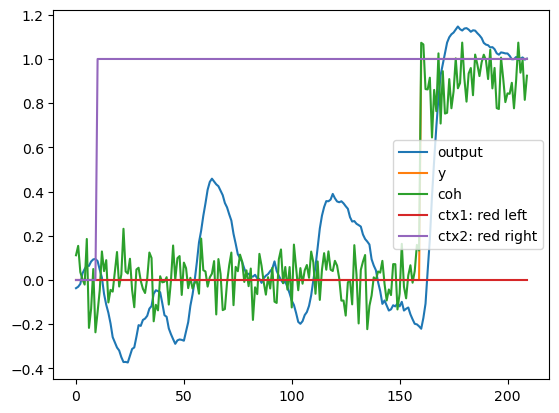

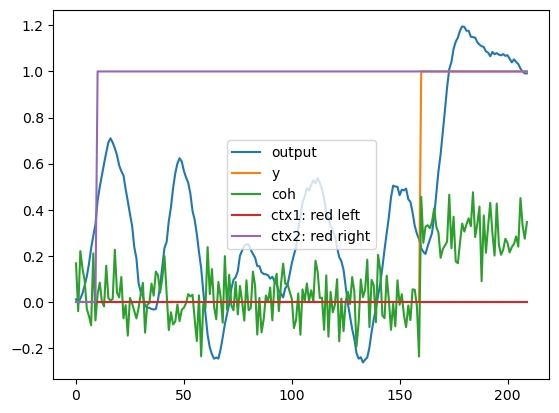

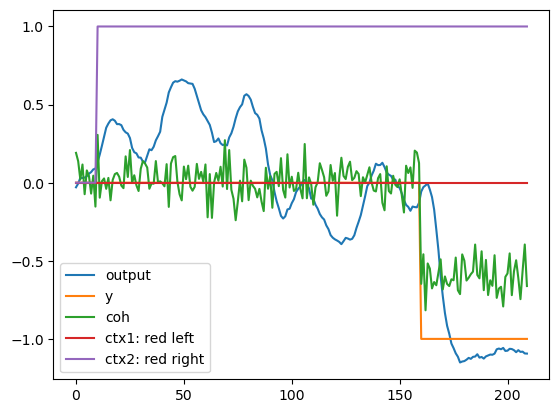

In [10]:
for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [10]:
traj1 = traj.detach().numpy()

# traj1 = np.tanh(traj1)
traj1 = np.max(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [9]:
for n in range(100,120):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

NameError: name 'tfRL' is not defined

<Figure size 640x480 with 0 Axes>

# plot the connectivity matrix


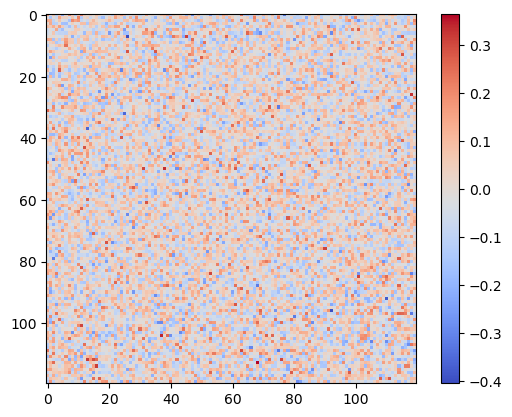

In [12]:
a = (net.wrec).detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('coolwarm')